# Language Game-Based Fake News Propagation Simulation

This notebook implements the language game-based approach to fake news propagation, replacing the epidemiological SIS model with a Bayesian language game approach based on collective inference.

## Overview

The simulation models how fake news propagates through a network of LLM agents using:
- Bayesian belief updates
- Metropolis-Hastings language games
- Active inference for action selection

You can run different experiments and visualize results directly in this notebook.

## Import Dependencies

First, let's import the necessary libraries and modules:

In [1]:
# Import standard libraries
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple, Optional, Any, Union

# Ensure mesa is installed
try:
    import mesa
    from mesa import Agent, Model
    from mesa.time import RandomActivation
    from mesa.datacollection import DataCollector
except ImportError:
    !pip install mesa
    import mesa
    from mesa import Agent, Model
    from mesa.time import RandomActivation
    from mesa.datacollection import DataCollector

# Ensure networkx is installed for later use
try:
    import networkx as nx
except ImportError:
    !pip install networkx
    import networkx as nx

'''
plt.style.use("dark_background")

for param in ['text.color', 'axes.labelcolor', 'xtick.color', 'ytick.color']:
    plt.rcParams[param] = '0.9'  # very light grey

for param in ['figure.facecolor', 'axes.facecolor', 'savefig.facecolor']:
    plt.rcParams[param] = '#212946'  # bluish dark grey

colors = [
    '#08F7FE',  # teal/cyan
    '#FE53BB',  # pink
    '#F5D300',  # yellow
    '#00ff41',  # matrix green
]
'''

# Configure plotting
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
#plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## Import the Language Game Model

There are two approaches:
1. Import the model from the language_game_model.py file
2. Redefine the model directly in this notebook

We'll try the first approach first, and if it fails, we'll implement the second approach.

In [2]:
# Try importing the model from the Python file
try:
    # Direct import may fail if file is not in the path
    from language_game_model import run_model, analyze_results
    print("Successfully imported the language game model from file!")
    imported_from_file = True
except ImportError:
    print("Could not import model from file. Will define it directly in the notebook.")
    imported_from_file = False

Could not import model from file. Will define it directly in the notebook.


If importing fails, we'll need to define the model directly in this notebook. For brevity, this cell will only be executed if the import above fails.

In [3]:
# Only run this if import failed
if not imported_from_file:
    # Constants for Bayesian inference
    TEMPERATURE = 0.7  # Temperature parameter for Metropolis-Hastings
    BETA = 1.0  # Inverse temperature for active inference
    BELIEF_THRESHOLD = 0.6  # Threshold for belief acceptance
    FREE_ENERGY_WEIGHT = 0.8  # Weight for free energy minimization in active inference
    
    # Define BeliefState class
    class BeliefState:
        """Class to represent agent's belief state using Bayesian principles."""
        def __init__(self, initial_belief: float = 0.0, certainty: float = 0.5):
            self.belief = initial_belief  # P(fake news is true)
            self.certainty = certainty    # Precision of belief
            self.evidence_history = []    # Store past evidence to track changes
            self.free_energy = 0.0        # Free energy of current belief state

        def update_with_evidence(self, new_evidence: float, source_trustworthiness: float) -> None:
            """Update belief using Bayesian update rule with evidence weight based on source trust."""
            # Store evidence for history tracking
            self.evidence_history.append((new_evidence, source_trustworthiness))
            
            # Prior (current belief)
            prior = self.belief
            
            # Likelihood P(evidence | hypothesis)
            weighted_evidence = new_evidence * source_trustworthiness
            
            # Bayes update
            likelihood = weighted_evidence if prior > 0.5 else (1 - weighted_evidence)
            posterior_unnormalized = likelihood * prior
            
            # Normalize with marginal likelihood
            marginal = (weighted_evidence * prior) + ((1 - weighted_evidence) * (1 - prior))
            if marginal > 0:  # Avoid division by zero
                posterior = posterior_unnormalized / marginal
                
                # Update belief with smoothing based on certainty
                self.belief = (self.certainty * posterior) + ((1 - self.certainty) * prior)
                
                # Increase certainty slightly with each update (learning)
                self.certainty = min(0.95, self.certainty + 0.01)
                
                # Calculate free energy
                prediction_error = -np.log(likelihood + 1e-10)
                kl_divergence = self.belief * np.log((self.belief + 1e-10) / (prior + 1e-10)) + \
                               (1 - self.belief) * np.log((1 - self.belief + 1e-10) / (1 - prior + 1e-10))
                self.free_energy = prediction_error + kl_divergence

        def reset_certainty(self) -> None:
            """Reset certainty when agent encounters contradictory evidence."""
            self.certainty = max(0.3, self.certainty - 0.2)
        
        def get_belief_state(self) -> str:
            """Get a categorical belief state for compatibility with the original model."""
            if self.belief < 0.3:
                return "susceptible"
            elif self.belief > 0.7:
                return "infected"
            else:
                # Check if previously believed (was infected) but now uncertain
                was_infected = any(e > 0.7 for e, _ in self.evidence_history[:max(0, len(self.evidence_history)-5)])
                return "recovered" if was_infected else "susceptible"
    
    # Define LanguageGameUtterance class
    class LanguageGameUtterance:
        """Class to represent utterances in the language game framework."""
        def __init__(self, 
                     content: str, 
                     belief_strength: float, 
                     source_agent_id: str,
                     is_official: bool = False):
            self.content = content
            self.belief_strength = belief_strength
            self.source_agent_id = source_agent_id
            self.is_official = is_official
            self.timestamp = 0  # To be set by the model
            
        def to_prompt_text(self) -> str:
            """Convert the utterance to text for prompting an LLM."""
            belief_text = "strongly believes" if self.belief_strength > 0.7 else \
                          "somewhat believes" if self.belief_strength > 0.3 else "doubts"
            
            source_text = "An official announcement" if self.is_official else f"Agent {self.source_agent_id}"
            
            return f"{source_text} {belief_text} the following: '{self.content}'"
    
    # Define DOAgent class
    class DOAgent(Agent):
        """Dynamic Opinion Agent (DOA) using language games and active inference."""
        def __init__(self, 
                     unique_id: int, 
                     model: Model, 
                     name: str, 
                     age: int, 
                     education: str,
                     traits: List[str], 
                     initial_belief: float = 0.0,
                     openness: float = 0.5,
                     confirmatory_bias: float = 0.5) -> None:
            super().__init__(unique_id, model)
            
            # Agent persona
            self.name = name
            self.age = age
            self.education = education
            self.traits = traits
            self.openness = openness
            self.confirmatory_bias = confirmatory_bias
            
            # Belief state using Bayesian framework
            initial_certainty = random.uniform(0.3, 0.7)  # Randomize initial certainty
            self.belief_state = BeliefState(initial_belief, initial_certainty)
            
            # Memory components
            self.short_term_memory = []  # Recent interactions
            self.long_term_memory = []   # Persistent beliefs and important interactions
            
            # Language game components
            self.utterances_heard = []  # Utterances heard from other agents
            self.current_utterance = None  # Current utterance the agent is making
            self.communication_history = []  # History of all communications
            
            # Active inference components
            self.expected_free_energy = 0.0  # Expected free energy for action selection
            self.action_space = ["listen", "share_belief", "question", "reflect"]  # Possible actions
            self.action_priors = {a: 1.0/len(self.action_space) for a in self.action_space}  # Equal priors

        def get_persona_prompt(self) -> str:
            """Generate a prompt describing the agent's persona for the LLM."""
            traits_str = ", ".join(self.traits)
            return (f"You are {self.name}, {self.age} years old with {self.education} education. "
                    f"Your personality traits include: {traits_str}. "
                    f"You are {'very open to new ideas' if self.openness > 0.7 else 'somewhat open to new ideas' if self.openness > 0.3 else 'rather closed to new ideas'}. "
                    f"You {'strongly tend to favor information that confirms your existing beliefs' if self.confirmatory_bias > 0.7 else 'somewhat tend to favor information that confirms your existing beliefs' if self.confirmatory_bias > 0.3 else 'try to evaluate information objectively'}.")

        def _generate_llm_response(self, prompt: str) -> str:
            """Generate a response from the LLM based on a prompt."""
            try:
                # For demo purposes, just return a simulated response
                belief_level = self.belief_state.belief
                certainty = self.belief_state.certainty
                
                # Simulate response based on belief and certainty
                if belief_level > 0.7:
                    return f"I believe this information is true. {random.choice(['It makes sense to me.', 'The evidence supports it.', 'I find it convincing.'])}"
                elif belief_level < 0.3:
                    # Define choices outside of f-string to avoid backslash issues
                    skeptical_phrases = ['It seems doubtful.', 'I need more evidence.', "This doesn't sound credible."]
                    return f"I'm skeptical about this information. {random.choice(skeptical_phrases)}"
                else:
                    # Define choices outside of f-string to avoid backslash issues
                    uncertain_phrases = ['I need to consider it more.', 'I have mixed feelings.', 'It could be true, but I am uncertain.']
                    return f"I'm not sure what to think about this. {random.choice(uncertain_phrases)}"
                    
            except Exception as e:
                print(f"Error generating LLM response: {e}")
                return "I'm still considering this information."

        def listen(self, utterance: LanguageGameUtterance) -> None:
            """Agent listens to an utterance from another agent."""
            # Store in short-term memory
            self.utterances_heard.append(utterance)
            self.short_term_memory.append(utterance)
            
            # Limit short-term memory size
            if len(self.short_term_memory) > 10:
                self.short_term_memory.pop(0)
                
            # Process the utterance through active inference
            self._process_utterance(utterance)

        def _process_utterance(self, utterance: LanguageGameUtterance) -> None:
            """Process an utterance using Bayesian inference and active inference."""
            # Calculate source trustworthiness
            if utterance.is_official:
                source_trust = 0.9
            else:
                # For other agents, trust is based on similarity and past interactions
                source_agent = self.model.get_agent_by_id(utterance.source_agent_id)
                similarity = self._calculate_agent_similarity(source_agent)
                source_trust = 0.3 + (0.6 * similarity)  # Scale to [0.3, 0.9]
            
            # Apply confirmatory bias
            belief_alignment = 1 - abs(self.belief_state.belief - utterance.belief_strength)
            biased_trust = (source_trust * (1 - self.confirmatory_bias)) + \
                           (belief_alignment * self.confirmatory_bias)
            
            # Convert utterance to evidence
            evidence_value = utterance.belief_strength
            
            # Update belief using Bayesian update
            self.belief_state.update_with_evidence(evidence_value, biased_trust)
            
            # Store important utterances in long-term memory
            if biased_trust > 0.7 or abs(self.belief_state.belief - evidence_value) > 0.5:
                if len(self.long_term_memory) >= 10:
                    self.long_term_memory.pop(0)
                self.long_term_memory.append(utterance)

        def _calculate_agent_similarity(self, other_agent) -> float:
            """Calculate similarity with another agent based on traits and beliefs."""
            # Handle case where other_agent is None or not a DOAgent
            if other_agent is None or not hasattr(other_agent, 'traits'):
                return 0.3  # Default similarity
                
            # Calculate trait similarity
            common_traits = set(self.traits).intersection(set(other_agent.traits))
            trait_similarity = len(common_traits) / max(len(self.traits), len(other_agent.traits))
            
            # Calculate belief similarity
            belief_similarity = 1 - abs(self.belief_state.belief - other_agent.belief_state.belief)
            
            # Calculate demographic similarity (age, education)
            age_similarity = 1 - (abs(self.age - other_agent.age) / 100)  # Normalize by max age difference
            edu_similarity = 1 if self.education == other_agent.education else 0.5
            
            # Weighted average with higher weight on belief similarity
            return (0.2 * trait_similarity + 0.4 * belief_similarity + 
                    0.2 * age_similarity + 0.2 * edu_similarity)

        def _metropolis_hastings_update(self, evidence: float, source_trust: float) -> bool:
            """Metropolis-Hastings algorithm for belief update."""
            # Current belief state (prior)
            current_belief = self.belief_state.belief
            
            # Propose a new belief state (influenced by evidence)
            proposed_shift = (evidence - current_belief) * source_trust
            
            # Add some noise for exploration
            noise = np.random.normal(0, 0.1 * (1 - self.belief_state.certainty))
            proposed_belief = current_belief + proposed_shift + noise
            
            # Ensure belief stays in [0,1] range
            proposed_belief = max(0.0, min(1.0, proposed_belief))
            
            # Calculate acceptance probability using Metropolis-Hastings
            # Likelihood of current and proposed beliefs given evidence
            current_likelihood = source_trust * (1 - abs(current_belief - evidence))
            proposed_likelihood = source_trust * (1 - abs(proposed_belief - evidence))
            
            # Prior probabilities (could incorporate other factors here)
            current_prior = 1.0  # Uniform prior for simplicity
            proposed_prior = 1.0
            
            # Calculate acceptance ratio
            acceptance_ratio = (proposed_likelihood * proposed_prior) / \
                              (current_likelihood * current_prior)
            
            # Accept or reject based on ratio
            if acceptance_ratio >= 1 or random.random() < acceptance_ratio:
                # Update belief if accepted
                self.belief_state.belief = proposed_belief
                return True
            else:
                return False

        def _minimize_free_energy(self) -> None:
            """Apply active inference by minimizing free energy."""
            # Calculate free energy for current belief state
            current_free_energy = self.belief_state.free_energy
            
            # Explore belief space to find lower free energy state
            for _ in range(5):  # Try a few iterations
                # Propose a small change to beliefs
                proposed_belief = self.belief_state.belief + np.random.normal(0, 0.05)
                proposed_belief = max(0.0, min(1.0, proposed_belief))
                
                # Calculate free energy for proposed belief
                # Prediction error component (simplified)
                evidence_values = [e for e, _ in self.belief_state.evidence_history[-5:]] if self.belief_state.evidence_history else [0.5]
                avg_evidence = sum(evidence_values) / len(evidence_values)
                prediction_error = abs(proposed_belief - avg_evidence)
                
                # Complexity/KL divergence component
                complexity = abs(proposed_belief - self.belief_state.belief)
                
                # Total free energy (weighted sum)
                proposed_free_energy = (0.7 * prediction_error) + (0.3 * complexity)
                
                # Accept if free energy is lower
                if proposed_free_energy < current_free_energy:
                    self.belief_state.belief = proposed_belief
                    self.belief_state.free_energy = proposed_free_energy
                    current_free_energy = proposed_free_energy

        def _calculate_expected_free_energy(self, action: str) -> float:
            """Calculate expected free energy for an action."""
            # Base components of expected free energy
            if action == "listen":
                # Listening has high epistemic value when uncertainty is high
                epistemic_value = 1 - self.belief_state.certainty
                pragmatic_value = 0.5  # Neutral pragmatic value
                
            elif action == "share_belief":
                # Sharing has high pragmatic value when certainty is high
                epistemic_value = 0.3  # Modest information gain
                pragmatic_value = self.belief_state.certainty
                
            elif action == "question":
                # Questioning has high epistemic value when belief is moderate
                mid_belief = abs(self.belief_state.belief - 0.5)
                epistemic_value = 0.7 * (1 - mid_belief)  # Higher for beliefs around 0.5
                pragmatic_value = 0.5
                
            elif action == "reflect":
                # Reflection has high epistemic value with conflicting evidence
                conflicting_evidence = False
                if len(self.belief_state.evidence_history) >= 3:
                    recent_values = [e for e, _ in self.belief_state.evidence_history[-3:]]
                    variance = np.var(recent_values) if recent_values else 0
                    conflicting_evidence = variance > 0.2
                    
                epistemic_value = 0.8 if conflicting_evidence else 0.4
                pragmatic_value = 0.6  # Moderately valuable for goal pursuit
                
            else:
                return 0.0  # Unknown action
            
            # Calculate expected free energy (lower is better in active inference)
            expected_free_energy = -(epistemic_value + pragmatic_value)
            
            # Incorporate action priors
            expected_free_energy += -np.log(self.action_priors.get(action, 0.1) + 1e-10)
            
            return expected_free_energy

        def select_action(self) -> str:
            """Select an action using active inference principles."""
            # Calculate expected free energy for each action
            action_values = {
                action: self._calculate_expected_free_energy(action)
                for action in self.action_space
            }
            
            # Convert to probabilities using softmax
            values = np.array(list(action_values.values()))
            probabilities = np.exp(-BETA * values) / np.sum(np.exp(-BETA * values))
            
            # Select action based on probabilities
            action_idx = np.random.choice(len(self.action_space), p=probabilities)
            selected_action = self.action_space[action_idx]
            
            # Update action priors (learning)
            for i, action in enumerate(self.action_space):
                if i == action_idx:
                    self.action_priors[action] = 0.9 * self.action_priors[action] + 0.1
                else:
                    self.action_priors[action] = 0.9 * self.action_priors[action]
                    
            return selected_action

        def generate_utterance(self) -> LanguageGameUtterance:
            """Generate an utterance to share with other agents."""
            # Create utterance content based on current beliefs and topic
            prompt = (
                f"Based on your current understanding of the topic '{self.model.fake_news_topic}', "
                f"express your opinion in a short statement. "
                f"Current belief level: {'high' if self.belief_state.belief > 0.7 else 'low' if self.belief_state.belief < 0.3 else 'moderate'}. "
                f"Certainty: {'high' if self.belief_state.certainty > 0.7 else 'low' if self.belief_state.certainty < 0.3 else 'moderate'}."
            )
            
            # Get content from LLM
            content = self._generate_llm_response(prompt)
            
            # Create and return utterance
            utterance = LanguageGameUtterance(
                content=content,
                belief_strength=self.belief_state.belief,
                source_agent_id=self.unique_id,
                is_official=False
            )
            
            self.current_utterance = utterance
            return utterance

        def reflect(self) -> None:
            """Agent reflects on recent interactions and updates beliefs."""
            # Skip reflection if no recent interactions
            if not self.utterances_heard:
                return
                
            # Create reflection prompt based on recent interactions
            recent_utterances = self.utterances_heard[-5:]
            utterance_texts = [u.to_prompt_text() for u in recent_utterances]
            
            prompt = (
                f"Based on the following recent interactions regarding '{self.model.fake_news_topic}', "
                f"reflect on your current beliefs. Do you find this information credible? Why or why not?\n\n"
                + "\n".join(utterance_texts)
            )
            
            # Get reflection from LLM
            reflection = self._generate_llm_response(prompt)
            
            # Extract belief signals from reflection (in production, would use NLP or LLM)
            positive_signals = ["credible", "believe", "true", "convinced", "evidence supports"]
            negative_signals = ["skeptical", "false", "unconvinced", "doubtful", "need more evidence"]
            
            # Count positive and negative signals
            positive_count = sum(1 for signal in positive_signals if signal.lower() in reflection.lower())
            negative_count = sum(1 for signal in negative_signals if signal.lower() in reflection.lower())
            
            # Convert to belief signal
            if positive_count > negative_count:
                reflection_belief = 0.6 + (0.4 * (positive_count / (positive_count + negative_count + 1)))
            elif negative_count > positive_count:
                reflection_belief = 0.4 * (1 - (negative_count / (positive_count + negative_count + 1)))
            else:
                reflection_belief = 0.5
                
            # Apply Metropolis-Hastings update
            self._metropolis_hastings_update(reflection_belief, 0.8)  # High trust in own reflection
            
            # Minimize free energy
            self._minimize_free_energy()
            
            # Update certainty based on reflection
            self.belief_state.certainty = min(0.95, self.belief_state.certainty + 0.05)
            
            # Clear heard utterances after reflection
            self.utterances_heard = []

        def step(self) -> None:
            """Agent's step function in the simulation."""
            # Select action using active inference
            action = self.select_action()
            
            # Execute action
            if action == "listen":
                # Agent already listens in interaction phase
                pass
            elif action == "share_belief":
                # Create utterance to share
                self.generate_utterance()
            elif action == "question":
                # Question most recent utterance (simulated by increasing uncertainty)
                if self.utterances_heard:
                    # Target the most recent utterance with highest impact
                    latest = self.utterances_heard[-1]
                    source_agent = self.model.get_agent_by_id(latest.source_agent_id)
                    if source_agent:
                        # Make the source agent less certain
                        source_agent.belief_state.certainty = max(0.2, source_agent.belief_state.certainty - 0.1)
            elif action == "reflect":
                self.reflect()
    
    # Define OfficialAgent class
    class OfficialAgent(DOAgent):
        """Official agent that issues announcements to counter fake news."""
        def __init__(self, 
                     unique_id: int, 
                     model: Model, 
                     intervention_schedule: List[int]) -> None:
            super().__init__(
                unique_id, 
                model, 
                name="Official Source", 
                age=0,  # Not relevant for official
                education="Expert",
                traits=["authoritative", "knowledgeable", "trustworthy"],
                initial_belief=0.0  # Officials know the news is fake
            )
            
            self.intervention_schedule = intervention_schedule
            self.is_official = True

        def step(self) -> None:
            """Official agent step function."""
            # Check if today is an intervention day
            if self.model.schedule.time in self.intervention_schedule:
                self.intervene()

        def intervene(self) -> None:
            """Issue an official intervention to counter fake news."""
            content = (
                f"Official Announcement regarding '{self.model.fake_news_topic}': "
                f"After careful investigation, we have determined that this information is false. "
                f"Please be cautious about sharing unverified claims."
            )
            
            utterance = LanguageGameUtterance(
                content=content,
                belief_strength=0.0,  # Strong disbelief in fake news
                source_agent_id=self.unique_id,
                is_official=True
            )
            
            # Send announcement to all agents
            for agent in self.model.schedule.agents:
                if hasattr(agent, 'listen') and agent.unique_id != self.unique_id:
                    agent.listen(utterance)
    
    # Define FPSWorldModel class
    class FPSWorldModel(mesa.Model):
        """Model class for the Fake news Propagation Simulation using language games."""
        def __init__(self, 
                     N: int = 20, 
                     fake_news_topic: str = "UFO sighting confirmed by government",
                     initial_infected_count: int = 1,
                     intervention_days: List[int] = None) -> None:
            """Initialize the fake news propagation model."""
            # Initialize parent class
            super().__init__()
            
            self.num_agents = N
            self.fake_news_topic = fake_news_topic
            self.initial_infected_count = initial_infected_count
            self.intervention_days = intervention_days or [5, 10, 15]
            
            # Set up the model
            self.schedule = RandomActivation(self)
            
            # Create regular agents
            self._create_agents()
            
            # Create official agent for interventions
            official_agent = OfficialAgent(self.num_agents + 1, self, self.intervention_days)
            self.schedule.add(official_agent)
            
            # Set up data collection
            self.datacollector = DataCollector(
                model_reporters={
                    "Susceptible": lambda m: self._count_susceptible(m),
                    "Infected": lambda m: self._count_infected(m),
                    "Recovered": lambda m: self._count_recovered(m),
                    "AverageBeliefStrength": lambda m: self._average_belief_strength(m),
                    "BeliefVariance": lambda m: self._belief_variance(m)
                },
                agent_reporters={
                    "Belief": lambda a: a.belief_state.belief if hasattr(a, 'belief_state') else None,
                    "Certainty": lambda a: a.belief_state.certainty if hasattr(a, 'belief_state') else None,
                    "State": lambda a: a.belief_state.get_belief_state() if hasattr(a, 'belief_state') else None
                }
            )
            
            # Collect initial data
            self.datacollector.collect(self)
            
            # Initialize interaction network (who interacts with whom)
            self.interaction_network = self._initialize_interaction_network()
            
            # Track simulation variables
            self.running = True
            self.day = 0

        def _create_agents(self) -> None:
            """Create and initialize agents for the simulation."""
            # Generate diverse personas
            personas = self._generate_diverse_personas(self.num_agents)
            
            # Create agents with those personas
            for i in range(self.num_agents):
                persona = personas[i]
                
                # Determine initial belief (mostly skeptical, a few believers)
                initial_belief = random.uniform(0.7, 0.9) if i < self.initial_infected_count else random.uniform(0.0, 0.3)
                
                # Create agent
                agent = DOAgent(
                    i, 
                    self,
                    name=persona["name"],
                    age=persona["age"],
                    education=persona["education"],
                    traits=persona["traits"],
                    initial_belief=initial_belief,
                    openness=persona["openness"],
                    confirmatory_bias=persona["confirmatory_bias"]
                )
                
                self.schedule.add(agent)

        def _generate_diverse_personas(self, count: int) -> List[Dict]:
            """Generate diverse agent personas."""
            personas = []
            
            # Sample names
            first_names = ["James", "Mary", "John", "Patricia", "Robert", "Jennifer", "Michael", 
                          "Linda", "William", "Elizabeth", "David", "Susan", "Richard", "Jessica", 
                          "Joseph", "Sarah", "Thomas", "Karen", "Charles", "Nancy"]
            
            last_names = ["Smith", "Johnson", "Williams", "Jones", "Brown", "Davis", "Miller", 
                         "Wilson", "Moore", "Taylor", "Anderson", "Thomas", "Jackson", "White", 
                         "Harris", "Martin", "Thompson", "Garcia", "Martinez", "Robinson"]
            
            # Sample education levels
            education_levels = ["High School", "Bachelor's Degree", "Master's Degree", "PhD", 
                               "No Formal Education", "Associate's Degree", "Technical Training"]
            
            # Sample traits
            trait_pool = ["analytical", "creative", "cautious", "adventurous", "introverted", 
                         "extroverted", "detail-oriented", "big-picture thinker", "emotional", 
                         "logical", "skeptical", "trusting", "conservative", "liberal", 
                         "traditional", "progressive", "practical", "idealistic"]
            
            for i in range(count):
                # Generate random persona
                name = f"{random.choice(first_names)} {random.choice(last_names)}"
                age = random.randint(18, 80)
                education = random.choice(education_levels)
                
                # Select 2-4 traits
                num_traits = random.randint(2, 4)
                traits = random.sample(trait_pool, num_traits)
                
                # Cognitive parameters
                openness = random.uniform(0.2, 0.9)
                confirmatory_bias = random.uniform(0.3, 0.8)
                
                # Create persona
                persona = {
                    "name": name,
                    "age": age,
                    "education": education,
                    "traits": traits,
                    "openness": openness,
                    "confirmatory_bias": confirmatory_bias
                }
                
                personas.append(persona)
                
            return personas

        def _initialize_interaction_network(self) -> Dict[int, List[int]]:
            """Initialize the interaction network that determines which agents interact."""
            network = {}
            
            # Get regular agents by their IDs
            regular_agent_ids = list(range(self.num_agents))
            
            # For each agent, connect to 3-5 other agents
            for agent_id in regular_agent_ids:
                # Determine number of connections
                num_connections = random.randint(3, min(5, self.num_agents - 1))
                
                # Create candidate list (all agents except self)
                candidates = [aid for aid in regular_agent_ids if aid != agent_id]
                
                # Get the agent and potential candidates
                agent = self.get_agent_by_id(agent_id)
                
                # Preferential attachment - agents with similar traits more likely to connect
                weights = []
                for candidate_id in candidates:
                    candidate = self.get_agent_by_id(candidate_id)
                    if agent and candidate:
                        similarity = agent._calculate_agent_similarity(candidate)
                        weights.append(similarity)
                    else:
                        weights.append(0.1)  # Default weight
                
                # Normalize weights
                total_weight = sum(weights) or 1  # Avoid division by zero
                weights = [w / total_weight for w in weights]
                
                # Select connections
                connections = []
                for _ in range(num_connections):
                    if candidates and weights:
                        selected_idx = np.random.choice(len(candidates), p=weights)
                        selected = candidates[selected_idx]
                        connections.append(selected)
                        
                        # Remove selected to avoid duplicates
                        weights.pop(selected_idx)
                        candidates.pop(selected_idx)
                        
                        # Renormalize weights if any candidates remain
                        if weights:
                            total_weight = sum(weights) or 1
                            weights = [w / total_weight for w in weights]
                    
                network[agent_id] = connections
            
            return network

        def get_agent_by_id(self, agent_id: int):
            """Get an agent by ID."""
            for agent in self.schedule.agents:
                if hasattr(agent, 'unique_id') and agent.unique_id == agent_id:
                    return agent
            return None

        def _run_language_game(self) -> None:
            """Run a language game interaction step between connected agents."""
            # For each agent ID in the interaction network
            for agent_id, connections in self.interaction_network.items():
                agent = self.get_agent_by_id(agent_id)
                if agent is None or not connections:
                    continue
                    
                # Randomly select which connections to interact with (1-3)
                num_interactions = random.randint(1, min(3, len(connections)))
                selected_connections = random.sample(connections, num_interactions)
                
                # Generate utterance if needed
                if not agent.current_utterance:
                    agent.generate_utterance()
                    
                # Share utterance with selected connections
                if agent.current_utterance:
                    for target_id in selected_connections:
                        target_agent = self.get_agent_by_id(target_id)
                        if target_agent and hasattr(target_agent, 'listen'):
                            target_agent.listen(agent.current_utterance)
                
                # Reset current utterance
                agent.current_utterance = None

        def _count_susceptible(self, model) -> int:
            """Count agents in susceptible state."""
            return sum(1 for agent in self.schedule.agents 
                      if agent.unique_id < self.num_agents  # Regular agent
                      and hasattr(agent, 'belief_state')
                      and agent.belief_state.get_belief_state() == "susceptible")
        
        def _count_infected(self, model) -> int:
            """Count agents in infected state."""
            return sum(1 for agent in self.schedule.agents 
                      if agent.unique_id < self.num_agents  # Regular agent
                      and hasattr(agent, 'belief_state')
                      and agent.belief_state.get_belief_state() == "infected")
        
        def _count_recovered(self, model) -> int:
            """Count agents in recovered state."""
            return sum(1 for agent in self.schedule.agents 
                      if agent.unique_id < self.num_agents  # Regular agent
                      and hasattr(agent, 'belief_state')
                      and agent.belief_state.get_belief_state() == "recovered")
        
        def _average_belief_strength(self, model) -> float:
            """Calculate average belief strength across agents."""
            beliefs = [agent.belief_state.belief for agent in self.schedule.agents 
                      if agent.unique_id < self.num_agents  # Regular agent
                      and hasattr(agent, 'belief_state')]
            return sum(beliefs) / len(beliefs) if beliefs else 0
        
        def _belief_variance(self, model) -> float:
            """Calculate variance in belief strength across agents."""
            beliefs = [agent.belief_state.belief for agent in self.schedule.agents 
                      if agent.unique_id < self.num_agents  # Regular agent
                      and hasattr(agent, 'belief_state')]
            return np.var(beliefs) if beliefs else 0

        def step(self) -> None:
            """Execute one step of the model."""
            # Increment day counter
            self.day += 1
            
            # Run individual agent steps
            self.schedule.step()
            
            # Run language game interactions
            self._run_language_game()
            
            # Collect data
            self.datacollector.collect(self)
    
    # Run function for the model
    def run_model(
        num_agents: int = 20,
        fake_news_topic: str = "UFO sighting confirmed by government",
        initial_infected: int = 1,
        intervention_days: List[int] = None,
        steps: int = 30
    ) -> mesa.model.Model:
        """Run the fake news propagation model."""
        if intervention_days is None:
            intervention_days = [5, 15, 25]
            
        # Create model
        model = FPSWorldModel(
            N=num_agents,
            fake_news_topic=fake_news_topic,
            initial_infected_count=initial_infected,
            intervention_days=intervention_days
        )
        
        # Run model
        for _ in range(steps):
            model.step()
            
        return model
    
    # Analysis function
    def analyze_results(model: mesa.model.Model) -> Dict:
        """Analyze results from the model run."""
        # Get agent data
        agent_data = model.datacollector.get_agent_vars_dataframe()
        
        # Get model data
        model_data = model.datacollector.get_model_vars_dataframe()
        
        # Calculate final stats
        final_stats = {
            "final_susceptible": model_data["Susceptible"].iloc[-1],
            "final_infected": model_data["Infected"].iloc[-1],
            "final_recovered": model_data["Recovered"].iloc[-1],
            "max_infected": model_data["Infected"].max(),
            "max_infected_day": model_data["Infected"].argmax(),
            "final_belief_avg": model_data["AverageBeliefStrength"].iloc[-1],
            "final_belief_var": model_data["BeliefVariance"].iloc[-1]
        }
        
        # Analyze impact of interventions
        intervention_days = model.intervention_days
        
        intervention_impact = {}
        for day in intervention_days:
            # Check if we have data for day and day+1
            if day < len(model_data) and day+1 < len(model_data):
                before = model_data["Infected"].iloc[day]
                after = model_data["Infected"].iloc[day+1]
                change = after - before
                pct_change = (change / before) * 100 if before > 0 else 0
                
                intervention_impact[day] = {
                    "before": before,
                    "after": after,
                    "absolute_change": change,
                    "percent_change": pct_change
                }
        
        return {
            "final_stats": final_stats,
            "intervention_impact": intervention_impact,
            "model_data": model_data,
            "agent_data": agent_data
        }
    
    print("Defined the language game model directly in the notebook!")

Defined the language game model directly in the notebook!


## Run a Basic Simulation

Now let's run a basic simulation with our model and visualize the results:

In [4]:
# Run a basic simulation
model = run_model(
    num_agents=20,
    fake_news_topic="A study shows that drinking lemon water cures cancer",
    initial_infected=2,  # Number of agents who initially believe the fake news
    intervention_days=[5, 15, 25],  # Days when official interventions occur
    steps=30  # Total simulation steps
)

# Analyze the results
results = analyze_results(model)

# Print summary statistics
print("Simulation Results:")
print("-" * 50)
for key, value in results["final_stats"].items():
    print(f"{key}: {value}")

# Print intervention impact
print("\nIntervention Impact:")
print("-" * 50)
for day, impact in results["intervention_impact"].items():
    print(f"Day {day}: {impact['percent_change']:.2f}% change in infected agents")

Simulation Results:
--------------------------------------------------
final_susceptible: 5
final_infected: 1
final_recovered: 14
max_infected: 5
max_infected_day: 20
final_belief_avg: 0.4189272320341438
final_belief_var: 0.030048093743563375

Intervention Impact:
--------------------------------------------------
Day 5: 0.00% change in infected agents
Day 15: 0.00% change in infected agents
Day 25: 0.00% change in infected agents


## Visualize Propagation Dynamics

Let's visualize how the fake news propagates through the network:

<Figure size 1200x600 with 0 Axes>

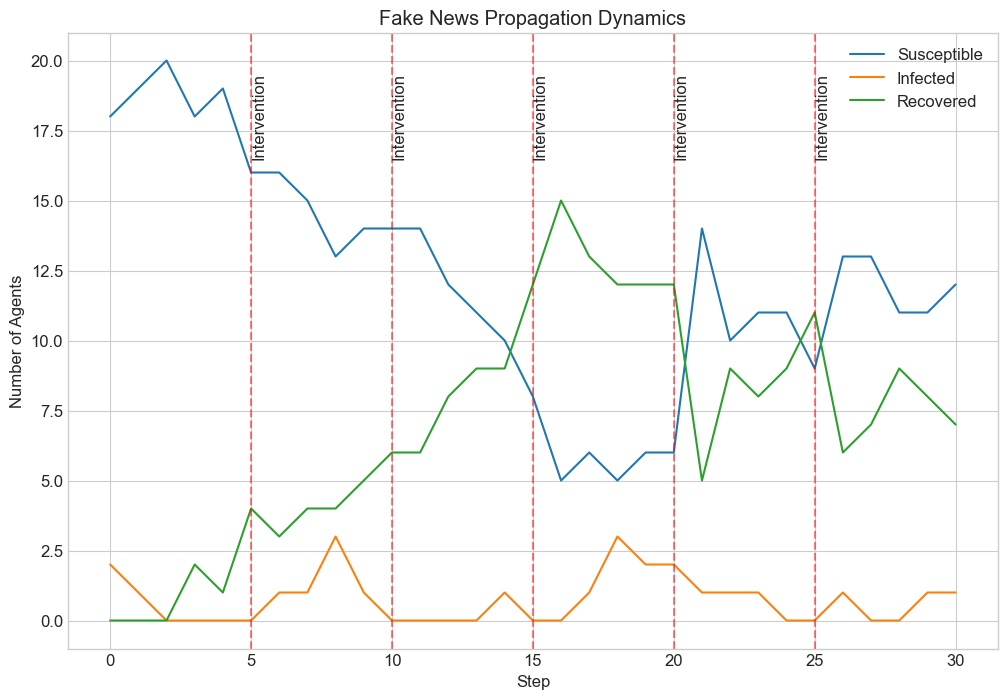

In [19]:
# Get model data
model_data = results["model_data"]

# Plot state counts over time
plt.figure(figsize=(12, 6))
model_data[["Susceptible", "Infected", "Recovered"]].plot()
plt.xlabel("Step")
plt.ylabel("Number of Agents")
plt.title("Fake News Propagation Dynamics")

# Add vertical lines for intervention days
for day in model.intervention_days:
    plt.axvline(x=day, color='r', linestyle='--', alpha=0.5)
    plt.text(day, model_data["Susceptible"].max()*0.98, f"Intervention", rotation=90, verticalalignment='top')

plt.legend(loc="best")
plt.grid(True)
plt.show()

## Visualize Belief Dynamics

One advantage of our language game approach is that we can track continuous belief states, not just discrete SIS categories:

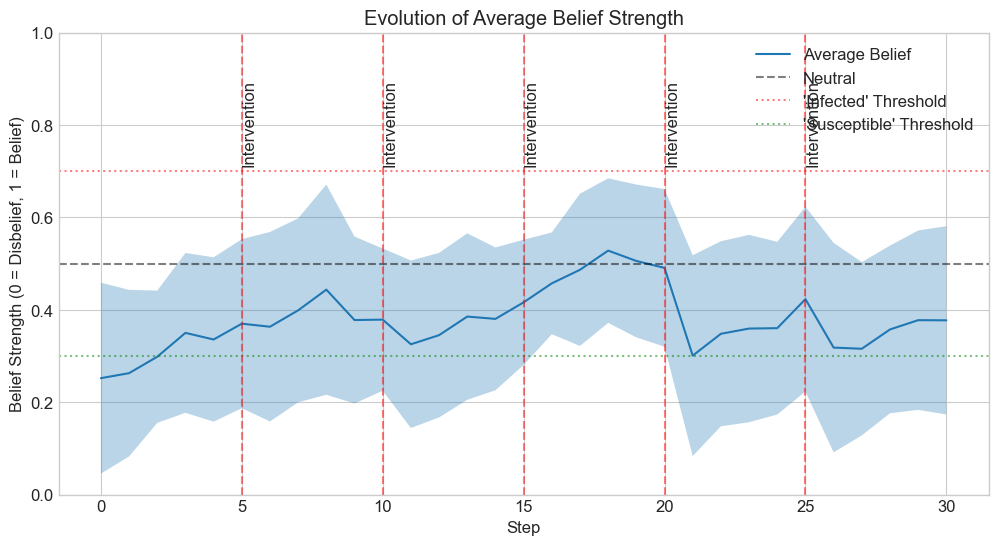

In [15]:
# Plot belief strength over time
plt.figure(figsize=(12, 6))
model_data["AverageBeliefStrength"].plot(label="Average Belief")
plt.fill_between(
    model_data.index,
    model_data["AverageBeliefStrength"] - np.sqrt(model_data["BeliefVariance"]),
    model_data["AverageBeliefStrength"] + np.sqrt(model_data["BeliefVariance"]),
    alpha=0.3
)

# Add neutral line and thresholds
plt.axhline(y=0.5, color='k', linestyle='--', alpha=0.5, label="Neutral")
plt.axhline(y=0.7, color='r', linestyle=':', alpha=0.5, label="'Infected' Threshold")
plt.axhline(y=0.3, color='g', linestyle=':', alpha=0.5, label="'Susceptible' Threshold")

# Add vertical lines for intervention days
for day in model.intervention_days:
    plt.axvline(x=day, color='r', linestyle='--', alpha=0.5)
    plt.text(day, 0.9, f"Intervention", rotation=90, verticalalignment='top')

plt.xlabel("Step")
plt.ylabel("Belief Strength (0 = Disbelief, 1 = Belief)")
plt.title("Evolution of Average Belief Strength")
plt.legend(loc="best")
plt.grid(True)
plt.ylim(0, 1)
plt.show()

## Visualize Individual Agent Beliefs

Let's examine how individual agents' beliefs evolve over time:

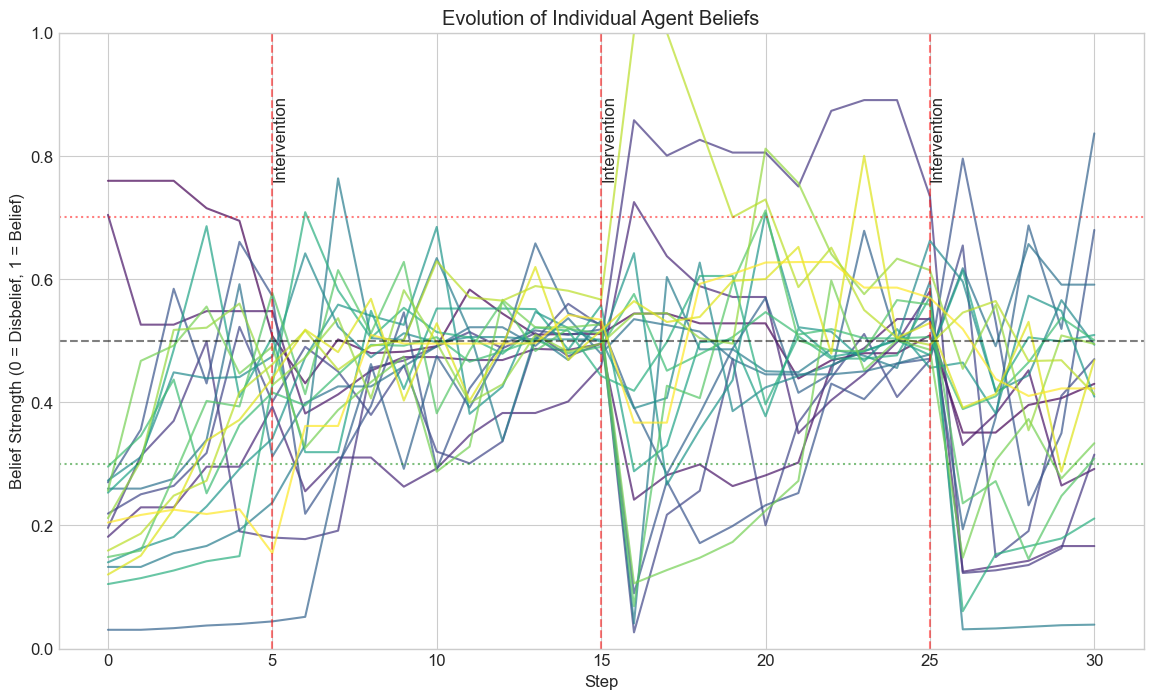

In [7]:
# Get agent data
agent_data = results["agent_data"]

# Get regular agents (exclude official agent)
regular_agents = list(range(model.num_agents))

# Plot belief evolution for each agent
plt.figure(figsize=(14, 8))

# Create a colormap for agents
colors = plt.cm.viridis(np.linspace(0, 1, len(regular_agents)))

# Plot belief evolution for each agent
for i, agent_id in enumerate(regular_agents):
    try:
        agent_beliefs = agent_data.xs(agent_id, level="AgentID")["Belief"]
        plt.plot(agent_beliefs, color=colors[i], alpha=0.7, label=f"Agent {agent_id}")
    except KeyError:
        continue

# Add neutral line and thresholds
plt.axhline(y=0.5, color='k', linestyle='--', alpha=0.5, label="Neutral")
plt.axhline(y=0.7, color='r', linestyle=':', alpha=0.5, label="'Infected' Threshold")
plt.axhline(y=0.3, color='g', linestyle=':', alpha=0.5, label="'Susceptible' Threshold")

# Add vertical lines for intervention days
for day in model.intervention_days:
    plt.axvline(x=day, color='r', linestyle='--', alpha=0.5)
    plt.text(day, 0.9, f"Intervention", rotation=90, verticalalignment='top')

plt.xlabel("Step")
plt.ylabel("Belief Strength (0 = Disbelief, 1 = Belief)")
plt.title("Evolution of Individual Agent Beliefs")
# Use a compact legend or no legend if too many agents
if len(regular_agents) <= 10:
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.ylim(0, 1)
plt.show()

## Visualize Network Structure

Let's visualize the agent network structure and see how it affects belief propagation:

In [8]:
# Create a network graph from the interaction network
G = nx.Graph()

# Add nodes (agents) - filter by agent ID
for i in range(model.num_agents):
    G.add_node(i)

# Add edges (connections)
for agent_id, connections in model.interaction_network.items():
    if agent_id < model.num_agents:  # Regular agent
        for target_id in connections:
            if target_id < model.num_agents:  # Regular agent
                G.add_edge(agent_id, target_id)

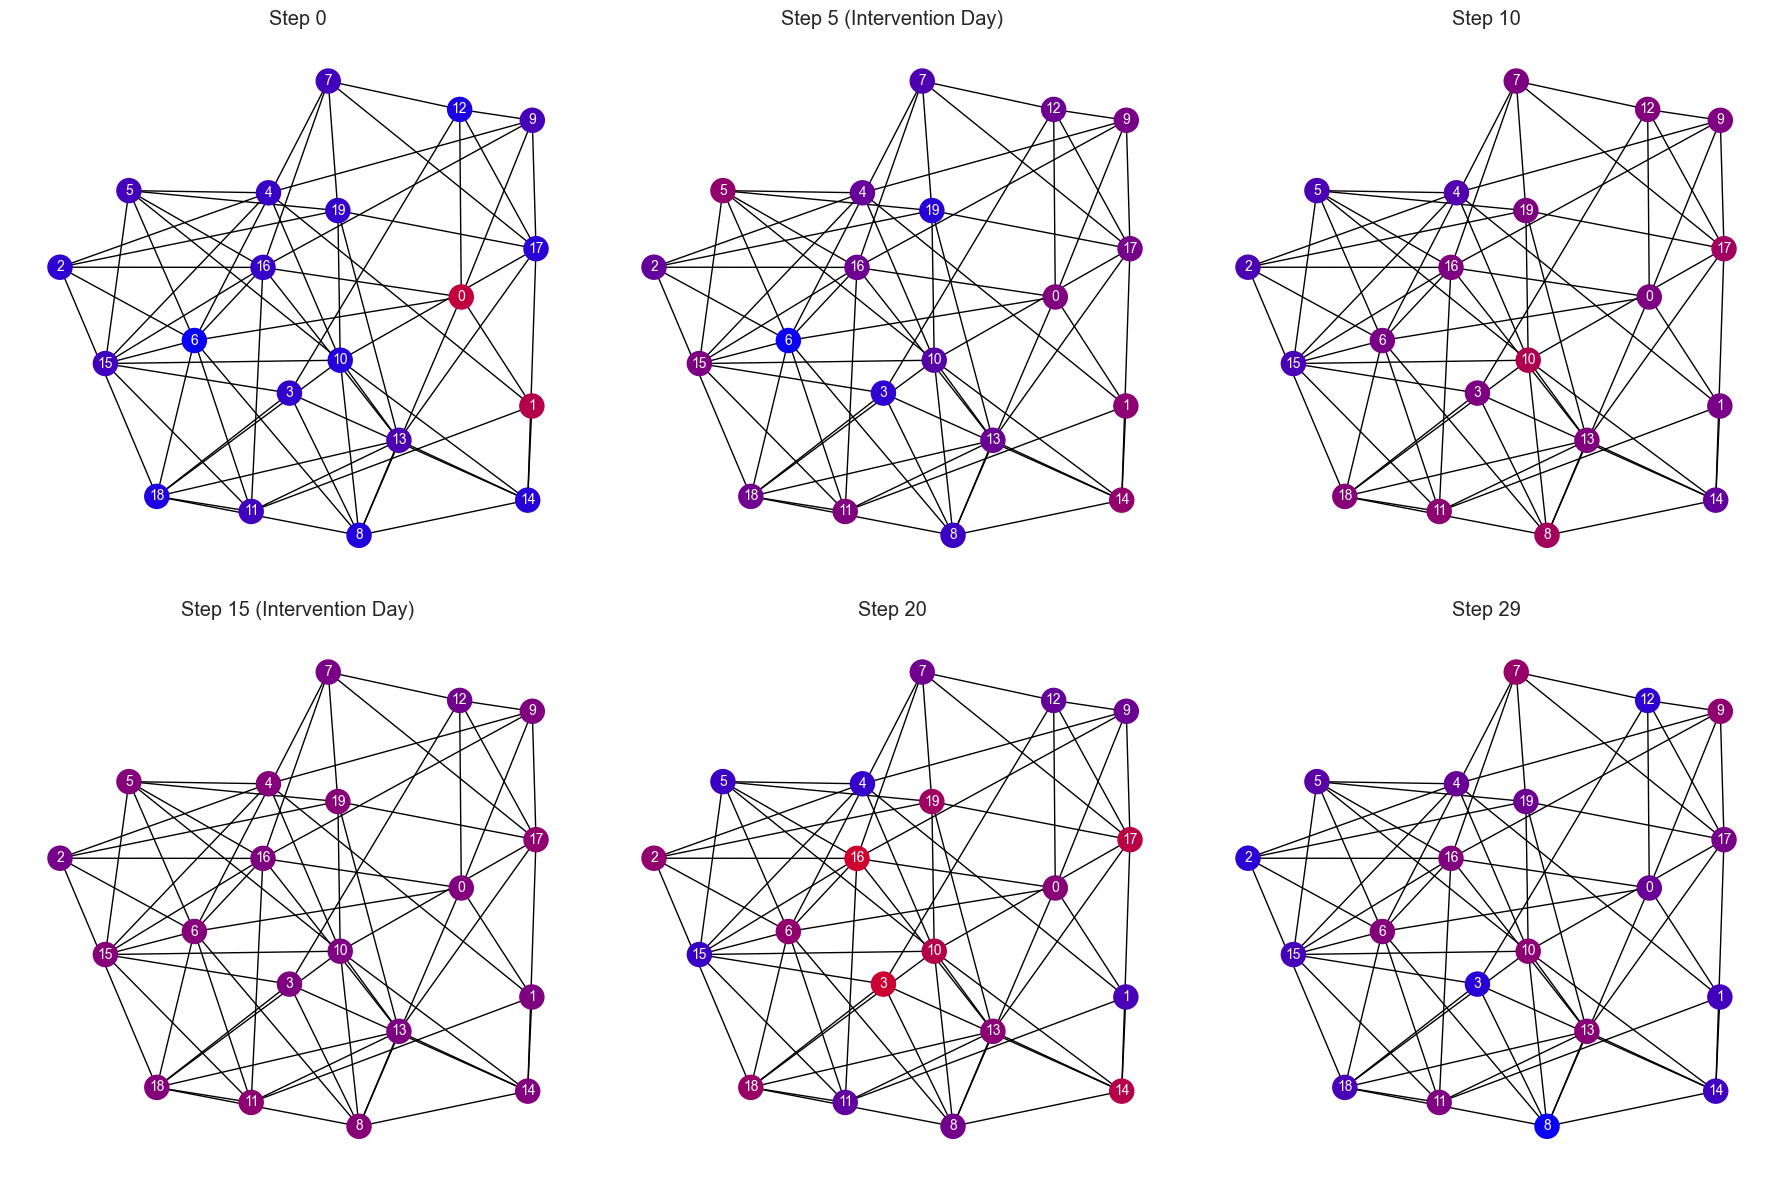

In [9]:
# Function to create and display a simple network visualization
def visualize_network(model, title="Agent Network"):
    """
    Create a simple visualization of the agent network.
    
    Args:
        model: The simulation model
        title: Title for the plot
    """
    # Create a network graph from the interaction network
    G = nx.Graph()
    
    # Add nodes (agents)
    for i in range(model.num_agents):
        G.add_node(i)
    
    # Add edges (connections)
    for agent_id, connections in model.interaction_network.items():
        if agent_id < model.num_agents:  # Regular agent
            for target_id in connections:
                if target_id < model.num_agents:  # Regular agent
                    G.add_edge(agent_id, target_id)
    
    # Create a figure
    plt.figure(figsize=(10, 8))
    
    # Simple fixed colors for nodes
    node_colors = ['skyblue'] * model.num_agents
    
    # Color initially infected agents red
    for i in range(model.initial_infected_count):
        node_colors[i] = 'red'
    
    # Draw the network
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, 
            node_color=node_colors,
            with_labels=True, 
            node_size=500, 
            font_size=12,
            font_weight='bold',
            edge_color='gray',
            width=1.5)
    
    # Add title
    plt.title(title, fontsize=16)
    
    # Add legend
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=15, label='Initially Infected'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='skyblue', markersize=15, label='Initially Susceptible')
    ]
    plt.legend(handles=legend_elements, loc='upper right', fontsize=12)
    
    plt.tight_layout()
    plt.show()

# Function to visualize belief strength for agents at the final step
def visualize_final_beliefs(model, results, title="Final Belief Strength"):
    """
    Visualize the final belief strength of agents.
    
    Args:
        model: The simulation model
        results: Results dictionary from analyze_results()
        title: Title for the plot
    """
    plt.figure(figsize=(10, 6))
    
    # Extract agent IDs and their final beliefs
    agent_data = results["agent_data"]
    final_step = agent_data.index.get_level_values('Step').max()
    
    # Get all agent IDs (excluding official agent)
    agent_ids = list(range(model.num_agents))
    
    # Prepare data for plotting
    agent_labels = [f"Agent {i}" for i in agent_ids]
    belief_values = []
    
    # Get belief values for each agent
    for agent_id in agent_ids:
        try:
            # Try to get belief value for this agent
            belief = agent_data.xs((agent_id, final_step), level=("AgentID", "Step"))["Belief"].iloc[0]
            belief_values.append(belief)
        except:
            # If error, use NaN
            belief_values.append(np.nan)
    
    # Create bar chart
    bars = plt.bar(agent_labels, belief_values, color=['red' if b > 0.7 else 'green' if b < 0.3 else 'orange' for b in belief_values])
    
    # Add threshold lines
    plt.axhline(y=0.7, color='red', linestyle='--', alpha=0.7, label="'Infected' Threshold")
    plt.axhline(y=0.3, color='green', linestyle='--', alpha=0.7, label="'Susceptible' Threshold")
    plt.axhline(y=0.5, color='black', linestyle=':', alpha=0.5, label="Neutral")
    
    # Add labels and title
    plt.xlabel("Agents")
    plt.ylabel("Belief Strength")
    plt.title(title)
    plt.ylim(0, 1)
    plt.xticks(rotation=90)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Create a time-series visualization of the network
time_points = [0, 5, 10, 15, 20, 29]  # Selected steps to visualize

plt.figure(figsize=(18, 12))

for i, time in enumerate(time_points):
    plt.subplot(2, 3, i+1)

    # Get belief states at this time point
    node_colors = []
    for node in G.nodes():
        try:
            # Extract a scalar value from the Series
            belief = agent_data.xs((node, time), level=("AgentID", "Step"))["Belief"].iloc[0]  
            # Color based on belief strength (red = believe, blue = disbelieve)
            node_colors.append((belief, 0, 1-belief))
        except KeyError:
            node_colors.append((0.5, 0.5, 0.5))  # Gray for missing data
    
    # Draw the network
    pos = nx.spring_layout(G, seed=42)  # Use same layout for all time points
    nx.draw(G, pos, node_color=node_colors, with_labels=True, node_size=300, font_size=10, font_color='white')
    
    # Add title with step and intervention info
    title = f"Step {time}"
    if time in model.intervention_days:
        title += " (Intervention Day)"
    plt.title(title)

plt.tight_layout()
plt.show()

## Compare Different Intervention Strategies

Now, let's compare different intervention strategies to see which is most effective:

In [10]:
# Define different intervention strategies
intervention_strategies = {
    "No Intervention": [],
    "Early (Day 5)": [5],
    "Middle (Day 15)": [15],
    "Late (Day 25)": [25],
    "Regular (Days 5, 15, 25)": [5, 15, 25],
    "Frequent (Days 5, 10, 15, 20, 25)": [5, 10, 15, 20, 25]
}

# Run simulations with each strategy
results_by_strategy = {}
models_by_strategy = {}

for strategy_name, intervention_days in intervention_strategies.items():
    print(f"Running simulation with {strategy_name}...")
    model = run_model(
        num_agents=20,
        fake_news_topic="A study shows that drinking lemon water cures cancer",
        initial_infected=2,
        intervention_days=intervention_days,
        steps=30
    )
    
    results = analyze_results(model)
    results_by_strategy[strategy_name] = results
    models_by_strategy[strategy_name] = model

Running simulation with No Intervention...
Running simulation with Early (Day 5)...
Running simulation with Middle (Day 15)...
Running simulation with Late (Day 25)...
Running simulation with Regular (Days 5, 15, 25)...
Running simulation with Frequent (Days 5, 10, 15, 20, 25)...


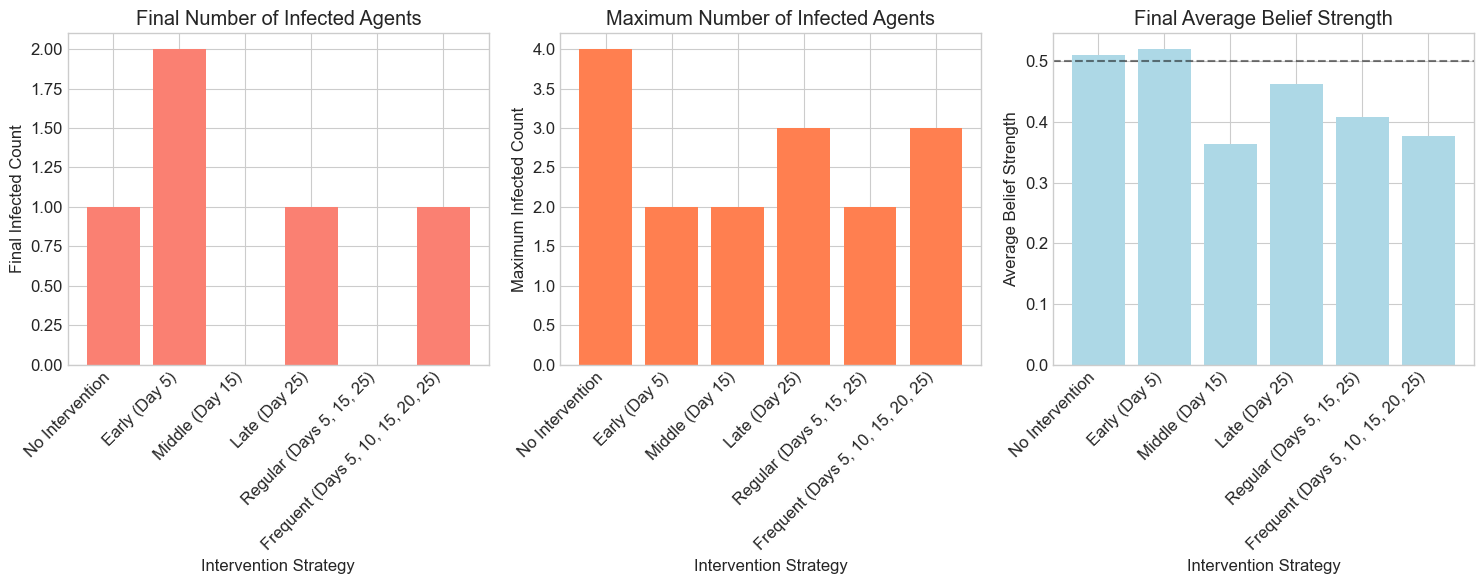

In [11]:
# Extract key metrics for comparison
strategies = list(results_by_strategy.keys())
final_infected = [results_by_strategy[s]["final_stats"]["final_infected"] for s in strategies]
max_infected = [results_by_strategy[s]["final_stats"]["max_infected"] for s in strategies]
final_belief_avg = [results_by_strategy[s]["final_stats"]["final_belief_avg"] for s in strategies]

# Create comparative bar chart
plt.figure(figsize=(15, 6))

# Plot final infected counts
plt.subplot(1, 3, 1)
plt.bar(strategies, final_infected, color='salmon')
plt.xlabel("Intervention Strategy")
plt.ylabel("Final Infected Count")
plt.title("Final Number of Infected Agents")
plt.xticks(rotation=45, ha="right")

# Plot max infected counts
plt.subplot(1, 3, 2)
plt.bar(strategies, max_infected, color='coral')
plt.xlabel("Intervention Strategy")
plt.ylabel("Maximum Infected Count")
plt.title("Maximum Number of Infected Agents")
plt.xticks(rotation=45, ha="right")

# Plot final average belief strength
plt.subplot(1, 3, 3)
plt.bar(strategies, final_belief_avg, color='lightblue')
plt.xlabel("Intervention Strategy")
plt.ylabel("Average Belief Strength")
plt.title("Final Average Belief Strength")
plt.xticks(rotation=45, ha="right")
plt.axhline(y=0.5, color='k', linestyle='--', alpha=0.5)  # Neutral line

plt.tight_layout()
plt.show()

## Compare Infected Counts Over Time

Let's compare how the number of infected agents evolves over time for each strategy:

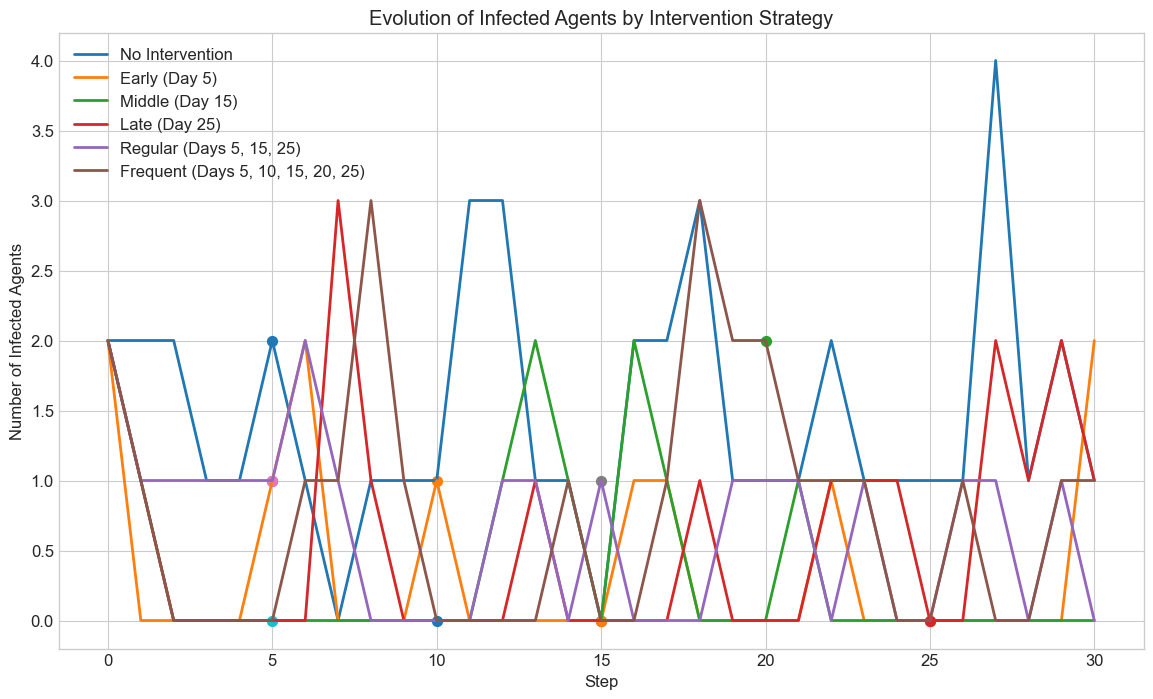

In [12]:
# Plot infected counts over time for each strategy
plt.figure(figsize=(14, 8))

for strategy_name, results in results_by_strategy.items():
    model_data = results["model_data"]
    plt.plot(model_data.index, model_data["Infected"], label=strategy_name, linewidth=2)
    
    # Add markers for intervention days
    intervention_days = models_by_strategy[strategy_name].intervention_days
    for day in intervention_days:
        if day < len(model_data):
            plt.scatter(day, model_data["Infected"].iloc[day], marker='o', s=50)

plt.xlabel("Step")
plt.ylabel("Number of Infected Agents")
plt.title("Evolution of Infected Agents by Intervention Strategy")
plt.legend(loc="best")
plt.grid(True)
plt.show()

## Conclusion

This notebook demonstrates the language game-based approach to fake news propagation simulation. The key advantages over the traditional SIS model are:

1. **Continuous Belief Representation**: We track beliefs as continuous values rather than discrete states
2. **Realistic Belief Dynamics**: The Metropolis-Hastings algorithm and Bayesian updates create more realistic belief changes
3. **Active Inference**: Agents make decisions based on minimizing expected free energy
4. **Social Factors**: Trust, similarity, and network structure influence belief propagation

This approach allows for more nuanced simulation of fake news propagation and intervention strategies.